<a href="https://colab.research.google.com/github/iciiiii/Forecasting_DailyPublicTransportation/blob/main/STI202303683_Suci_Oktavia_DL_Forecasting_DailyPublicTransportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT LIBRARY**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


**Data Preprocessing**

In [6]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
df = pd.read_csv('/content/drive/MyDrive/Public_Transportation/DailyBoardingTotals.csv', parse_dates=['service_date'])
df.dropna(inplace=True)
df.sort_values('service_date', inplace=True)

# Feature engineering
df['day_name'] = df['service_date'].dt.day_name()
df['month'] = df['service_date'].dt.month
df['is_weekend'] = df['day_name'].isin(['Saturday', 'Sunday']).astype(int)
df['ticket_price'] = 2.50  # asumsi tetap

# Tambahkan musim
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'
df['season'] = df['month'].apply(get_season)

# One-hot encoding
df = pd.get_dummies(df, columns=['day_name', 'season', 'day_type'], drop_first=True)

# Pilih fitur dan target
features = ['bus', 'rail_boardings', 'ticket_price', 'is_weekend'] + \
           [col for col in df.columns if 'day_name_' in col or 'season_' in col or 'day_type_' in col]
target = 'total_rides'
# Normalisasi
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features + [target]])

# Buat sequence time series
def create_sequences(data, n_steps=7):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :-1])  # fitur
        y.append(data[i+n_steps, -1])     # target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, n_steps=7)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

Mounted at /content/drive


**Model Definition**

In [7]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    LSTM(128, return_sequences=True, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**LOSS FUNCTION & OPTIMIZER**

In [8]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 128)         │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,249 (489.25 KB)

 Trainable params: 125,249 (489.25 KB)

 Non-trainable params: 0 (0.00 B)

**Trainig Model**

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# Training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    ],
    verbose=0
)

# Ringkasan akhir
best = np.argmin(history.history['val_loss'])
print(f"Best Epoch: {best+1} | Train Loss: {history.history['loss'][best]:.4f} | Val Loss: {history.history['val_loss'][best]:.4f}")



Best Epoch: 4 | Train Loss: 0.0074 | Val Loss: 0.0061


**Plot Prediction**

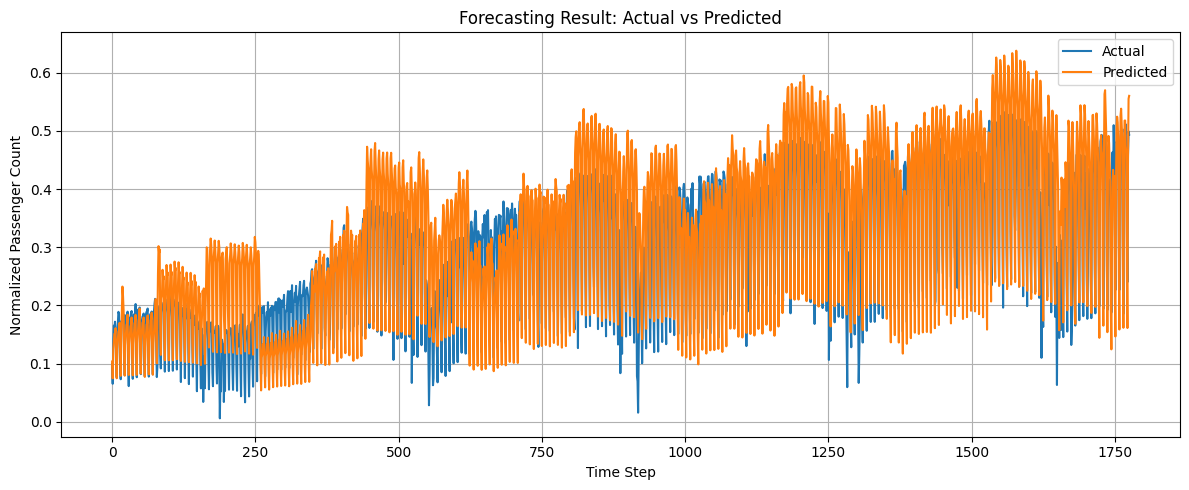

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Forecasting Result: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Normalized Passenger Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Model Evaluation**

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Cetak hasil
print("===== MODEL EVALUATION RESULTS =====")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
===== MODEL EVALUATION RESULTS =====
RMSE : 0.08
MAE  : 0.06
R²   : 0.5679
